SUSF salary data obtained from [here](https://prod.flbog.net:4445/pls/apex/f?p=140:1:0:::::). The data contains payroll information on the employee's of  Florida's 12 State Universities. In particular, I analyze the following

* New College salaries compared relative to the other members of the SUS.
* Adminstrative salaries compared to faculty salaries.

In [1]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import warnings
#from IPython.core.pylabtools import figsize
warnings.filterwarnings('ignore')

# Get data
if not os.path.exists('./emp.csv'):
    !wget -O emp.csv https://prod.flbog.net:4445/pls/apex/f?p=140:30:0
df = pd.read_csv('./emp.csv')

#Clean column names
df.columns = [x.strip().lower().replace(' ', '_') for x in df.columns]
unis = ['FAMU', 'FAU', 'FGCU', 'FIU', 'FPU', 'FSU', 'NCF', 'UCF', 'UF', 'UNF','USF', 'UWF']

In [2]:
uni_colors = sns.color_palette("husl", len(unis))
#uni_colors = sns.color_palette(n_colors=len(unis))
uni_color_map = {uni: color for uni, color in zip(unis, uni_colors)}

# Comparison of University Salary Expenditure

We begin by asking a natural question: what schools receive the most money? I answer this by computing the total salary amounts by university and plotting

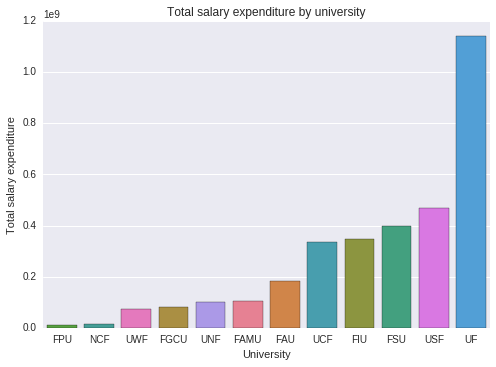

In [3]:
sal_totals_by_uni = df.groupby('university').apply(lambda x: np.sum(x['annual_salary'].dropna()))
sal_totals_by_uni = sal_totals_by_uni.sort_values()
sal_totals_by_uni = pd.DataFrame({'uni_salary_expenditure': sal_totals_by_uni})
sal_totals_by_uni['prop_total_salary_expenditure'] = sal_totals_by_uni['uni_salary_expenditure'] /\
                                                     sal_totals_by_uni['uni_salary_expenditure'].sum()

    
sal_totals_by_uni_2 = sal_totals_by_uni.reset_index()

sns.barplot(x='university', y='uni_salary_expenditure', 
            data=sal_totals_by_uni_2, estimator=np.sum, palette=uni_color_map)
plt.ylabel('Total salary expenditure')
plt.title('Total salary expenditure by university')
plt.xlabel('University')

Clearly there is a significant range of dollars allocated. However, the size of a university is an obvious confounding factor. To account for size, we must normalize the table. The most natural choice for doing so is by the student population. Headcounts by university for the Fall 2015 semester were obtained from [here](http://www.flbog.edu/resources/_doc/factbooks/quickfacts/SUS_Headcount_Enrollment_1905-present_2015-7-28.xls).

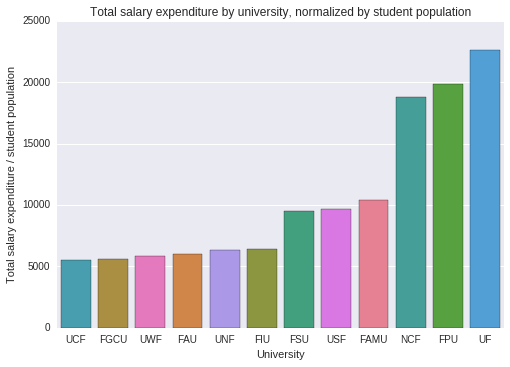

In [4]:
#Get data
if not os.path.exists('./SUS_Headcount_Enrollment_1905-present_2015-7-28.xls'):
    !wget http://www.flbog.edu/resources/_doc/factbooks/quickfacts/SUS_Headcount_Enrollment_1905-present_2015-7-28.xls

df_pop = pd.read_excel('./SUS_Headcount_Enrollment_1905-present_2015-7-28.xls', skiprows=4)
max_year_ind = df_pop['Year'].idxmax()
latest_pop = df_pop.loc[max_year_ind][unis]
total_uni_sal_by_student_pop = sal_totals_by_uni['uni_salary_expenditure'] / latest_pop
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.sort_values()

k = 'uni_salary_expenditure_by_n_students'
total_uni_sal_by_student_pop = pd.DataFrame({k: total_uni_sal_by_student_pop})
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.reset_index()
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.rename_axis({'index': 'university'}, axis=1)
total_uni_sal_by_student_pop[k] = total_uni_sal_by_student_pop[k].astype('float')
sns.barplot(x='university', y=k, data=total_uni_sal_by_student_pop, palette=uni_color_map)
plt.ylabel('Total salary expenditure / student population')
plt.title('Total salary expenditure by university, normalized by student population')
plt.xlabel('University')

This indicates that NCF is fairly high on the list of salary dollars per student.

# Comparison of salaries for Faculty, Administration, and Staff

The data contains salary information for all employees in the SUSF. This includes a variety of titles, a few of which are faculty, a few of which are administration, most of which are staff. The number of unique titles is 4124, which is cumbersome to manually categorize.To assist, I categorize titles into faculty, administration, and staff using keyword substring matching. I then filter these (much smaller) lists appropriately to exclude mismatches. I use these lists to define what titles are faculty, admin, and staff, and then create an indicator variable on the data.

In [5]:
positions = ['faculty', 'admin', 'staff']
pos_colors = sns.color_palette(n_colors=len(positions))
pos_color_map = {pos: color for pos, color in zip(positions, pos_colors)}

In [6]:
titles = df['class_title'].unique()
FAC_KEY_WORDS = ['professor', 'faculty', 'instructor', 'lecturer']
fac_matches = []
for T in titles:
    t = str(T).lower()
    for kw in FAC_KEY_WORDS:
        if kw in t:
            fac_matches.append(T)

In [7]:
faculty_titles = ['PROFESSOR', 'ASSOCIATE PROFESSOR', 'INSTRUCTOR', 'UNIVERSITY SCHOOL INSTRUCTOR',
                  'ASSISTANT PROFESSOR', 'UNIVERSITY SCHOOL ASSISTANT PROFESSOR', 'INSTRUCTOR LIBRARIAN', 
                  'LECTURER', 'DISTINGUISHED PROFESSOR','FACULTY (GENERIC)',
                  'UNIVERSITY SCHOOL ASSOCIATE PROFESSOR','UNIVERSITY SCHOOL PROFESSOR',
                  'GRADUATE RESEARCH PROFESSOR', 'PROVOST/ASSOC. PROFESSOR','ADJUNCT FACULTY',
                  'DEAN/ASSOCIATE PROFESSOR','INSTRUCTOR I','ASSOC PROFESSOR']

In [8]:
ADMIN_KEY_WORDS = ['president', 'chancellor', 'registrar'
                   'board' 'admin', 'provost', 'dean', 'vp']
admin_matches = []
for T in titles:
    t = str(T).lower()
    for kw in ADMIN_KEY_WORDS:
        if kw in t:
            #set_trace()
            admin_matches.append(T)
            
admin_titles = admin_matches

In [9]:
def identify_position(x):
    if x in faculty_titles:
        return 'faculty'
    elif x in admin_titles:
        return 'admin'
    else:
        return 'staff'

In [10]:
df['position_indicator'] = df['class_title'].apply(identify_position)

In [11]:
sal_by_uni_and_title = df.groupby(['university', 'position_indicator']).apply(lambda x: np.sum(x['annual_salary'].dropna()))
sal_by_uni_and_title = pd.DataFrame({'salary_expenditure': sal_by_uni_and_title})
#Get counts of the number of positions for each title type
sal_by_uni_and_title['N_pos'] = df.groupby(['university', 'position_indicator']).apply(lambda x: len(x['annual_salary'].dropna()))
#Compute mean salary by type and uni
sal_by_uni_and_title['mean_salary_per_pos'] = sal_by_uni_and_title['salary_expenditure'] / \
                                                         sal_by_uni_and_title['N_pos']

In [12]:
sal_exp_per_student = sal_by_uni_and_title.reset_index(level='position_indicator')['salary_expenditure'] / latest_pop
sal_exp_per_student = sal_exp_per_student.reset_index(drop=True)
sal_by_uni_and_title = sal_by_uni_and_title.reset_index()
sal_by_uni_and_title['sal_exp_per_student'] = sal_exp_per_student
sal_by_uni_and_title = sal_by_uni_and_title.sort_values(['university', 'position_indicator'])

Given these categorizations, we can breakdown the salary data to compare faculty, admins, and staff. I plot the salary expenditure by university and position type below. Since staff tend to far outnumber the number of faculty and administration, we normalize by the number of positions in each category, 

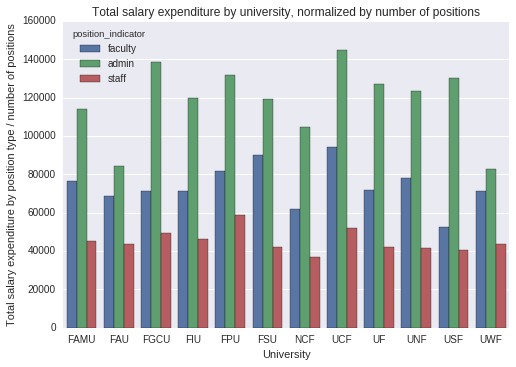

In [13]:
sns.barplot(x='university', y='mean_salary_per_pos', 
            hue='position_indicator', data=sal_by_uni_and_title,
            palette=pos_color_map, hue_order=positions)
plt.ylabel('Total salary expenditure by position type / number of positions')
plt.xlabel('University')
plt.title('Total salary expenditure by university, normalized by number of positions')

We see that the mean administration salary is uniformly greater than that of faculty or staff.

Lastly, I plot the distributions of salaries by position type.

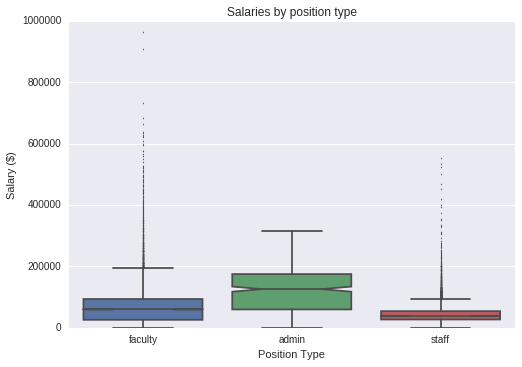

In [14]:
sns.boxplot(y = "annual_salary", x = "position_indicator", 
            data=df, notch = True, fliersize=1.5,
            palette=pos_color_map, order=positions)
plt.ylabel('Salary ($)')
plt.xlabel('Position Type')
plt.title('Salaries by position type')

The plot indicates that the median salary for faculty is lower than that of the administration. However, the faculty have a much greater range than the administration, with many outliers.